# House Prices
## 4. Regularized Linear Models
[캐글]: https://www.kaggle.com/c/house-prices-advanced-regression-techniques <br>
[참고 커널모음] :https://subinium.github.io/kaggle-tutorial/house-prices <br>
해당 커널 필사 시작일 : 2020-12-23

#### Python Tutorials
아래 튜토리얼 하나씩 필사할 예정

> * 1. Comprehensive Data Exploration with Python (필사 시작일 : 2020-09-01)
https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

> * 2. House Prices EDA (필사 시작일 : 2020-09-04) (마무리한 날짜: 2020-10-25)
https://www.kaggle.com/dgawlik/house-prices-eda

> * 3. A Study on Regression Applied to the Ames Dataset (필사 시작일 :2020-11-15)
https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

> * 4. Regularized Linear Models
https://www.kaggle.com/apapiu/regularized-linear-models

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [86]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [87]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [88]:
train.shape

(1460, 81)

In [89]:
test.shape

(1459, 80)

In [90]:
# train-set, test-set을 합침
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

---------------------------------------------
## Data preprocessing
여기서는 특별한 것들은 하지 않을것임.

* feature에 로그를 취함으로써, skewed한 수치형 데이터를 normal하게 만들기
* 범주형 변수는 더미변수만들기.
* 수치형 데이터의 결측치는 평균값으로 대체

#### 방법
* train set, test set을 하나의 데이터로 합쳐서 데이터 변환을 해주고나서 다시 분리시켜줌.

**1. 로그변환**
* SalePrice에 로그를 취해주고
* 수치형 변수 중 왜도가 0.75보다 큰 변수도 로그취해줌

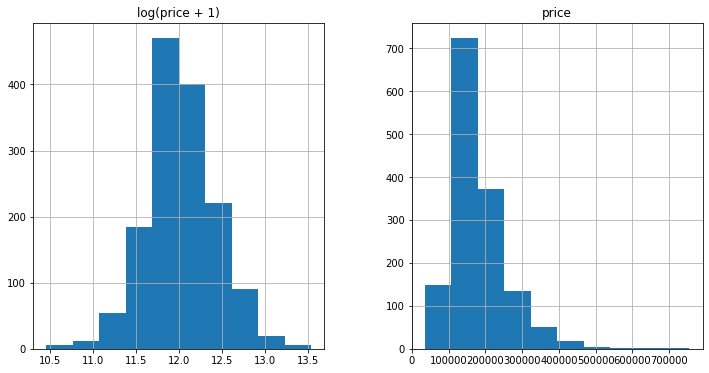

In [91]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist();

In [92]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# 수치형 데이터들의 왜도
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

# 왜도가 0.75보다큰 데이터는 로그변환
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [26]:
skewed_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [27]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,4.110874,RL,4.189655,9.042040,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2008,WD,Normal
1,3.044522,RL,4.394449,9.169623,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,5,2007,WD,Normal
2,4.110874,RL,4.234107,9.328212,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,9,2008,WD,Normal
3,4.262680,RL,4.110874,9.164401,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2006,WD,Abnorml
4,4.110874,RL,4.442651,9.565284,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,12,2008,WD,Normal


**2. 더미변수**

In [93]:
all_data=pd.get_dummies(all_data)

**3. 컬럼의 평균값으로 결측치 채우기**

In [94]:
all_data=all_data.fillna(all_data.mean())

**4. 모델링을 위한 train,test데이터분할**

In [95]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

------------------------------------------------------
## Models
* L1 (Lasso), L2(Ridge) regularization을 모두 사용해볼것이다.
* 모델을 평가하고 최고의 tuning파라미터를 선택하기위해 교차검증 rmse 를 도출하는 함수를 정의할것이다.

### (1) Ridge Model
* 릿지모델에서 메인 튜닝 파라미터는 alpha값. 모델이 얼마나 유연한지를 측정하는 규제 파라미터이다. 
* 규제가 강할수록 모델이 overfit될 가능성이 적다.
    * alpha의 default값은 1이고, 높을수록 Regularization을 강화하여 계수를 0에 가깝게 만듬.
* 하지만, 동시에 유연성을 잃을수있고, 데이터의 모든 signal을 발견하기 어려울수있다.

In [96]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

# 회귀 문제에서 scoring은 neg_mean_squared_error를 사용했지만, 분류문제에서는 accuracy사용.
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [97]:
model_ridge=Ridge()

In [98]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

In [99]:
# alphas개수 11개, 결과도 11개
cv_ridge

[0.13893637694024513,
 0.13777538277187878,
 0.13501433618086014,
 0.13136184989399582,
 0.12864892446111878,
 0.12782179689257286,
 0.12733734668670774,
 0.12752940439753804,
 0.12895888148450046,
 0.13099437857191423,
 0.13316366423370257]

In [100]:
# cross-val을 5번했으므로 값도 5개나옴.
rmse_cv(Ridge())

array([0.11383481, 0.13876091, 0.13696888, 0.11193148, 0.15531317])

In [101]:
rmse_cv(Ridge()).mean()

0.13136184989399582

Text(0, 0.5, 'rmse')

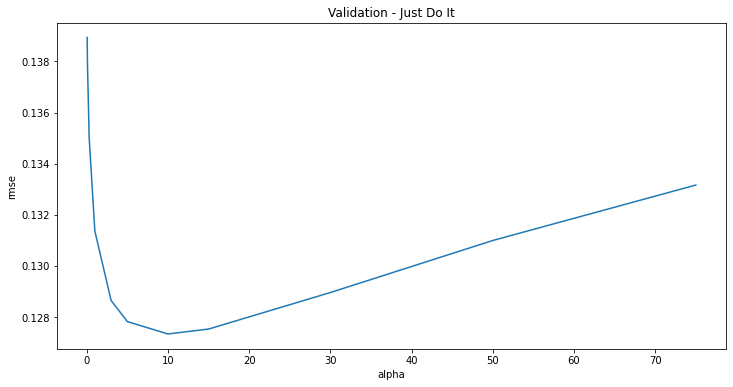

In [102]:
cv_ridge=pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title='Validation - Just Do It')
plt.xlabel('alpha')
plt.ylabel('rmse')

* alpha값이 일정값에 다다를때까진 rmse값이 작아지다가, 다시 올라가는 형태
* alpha값이 너무 커지면 규제가 너무 강해져서 모델이 데이터의 모든 복잡성을 발견하기 어렵다. 
* 반면에 alpha가 너무 작으면 모델은 overfit된다.
    * 위 plot을 보았을때, alpha=10이 가장 적절하다.

In [103]:
# 릿지모델에서 가장작은 rmse값은아래와같다.
# 0.127
cv_ridge.min()

0.12733734668670774

### (2) Lasso Model
* 라쏘 모델로 feature selection도 가능.(계수확인)

In [104]:
# Lasso는 cross-val 안함.
model_lasso=LassoCV(alphas=[1, 0.1, 0.001, 0.0005]).fit(X_train,y)

In [105]:
# 0.1225 로 Lasso모델이 Ridge모델보다 rmse평균값이 적게나옴. good!
rmse_cv(model_lasso).mean()

0.12256735885048124

In [108]:
# 라쏘모델에서의 각 feature별 계수
coef=pd.Series(model_lasso.coef_, index=X_train.columns)
coef

MSSubClass              -0.007480
LotFrontage              0.000000
LotArea                  0.071826
OverallQual              0.053160
OverallCond              0.043027
                           ...   
SaleCondition_AdjLand    0.000000
SaleCondition_Alloca    -0.000000
SaleCondition_Family    -0.007925
SaleCondition_Normal     0.019666
SaleCondition_Partial    0.000000
Length: 288, dtype: float64

In [109]:
# 110개의 feature를 선택하고 178개 제거
print('Lasso picked' + str(sum(coef!=0)) + "variables and eliminatied the other"+str(sum(coef==0))+'variables')

Lasso picked110variables and eliminatied the other178variables


* 데이터에 다중공선성이 많으면, 선택된 Feature들이 정확한것은 아니다. 
* 여기서 해볼수있는 것은 Lasso를 boostrapped 로 몇번 돌려보고 feature selection이 얼마나 안정적인지 (동일한 feature가 계속 feature로 선택되는지) 를 살펴본다.

In [110]:
# 중요한 coefficient확인
imp_coef=pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
imp_coef

RoofMatl_ClyTile        -0.704161
MSZoning_C (all)        -0.292023
Condition2_PosN         -0.190552
Neighborhood_Edwards    -0.052560
SaleCondition_Abnorml   -0.047116
MSZoning_RM             -0.037698
CentralAir_N            -0.035440
GarageCond_Fa           -0.031688
LandContour_Bnk         -0.030934
SaleType_WD             -0.030656
OverallQual              0.053160
KitchenQual_Ex           0.063709
Exterior1st_BrkFace      0.070464
Neighborhood_NridgHt     0.071620
LotArea                  0.071826
Functional_Typ           0.072597
Neighborhood_NoRidge     0.085717
Neighborhood_Crawfor     0.105138
Neighborhood_StoneBr     0.112493
GrLivArea                0.400009
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

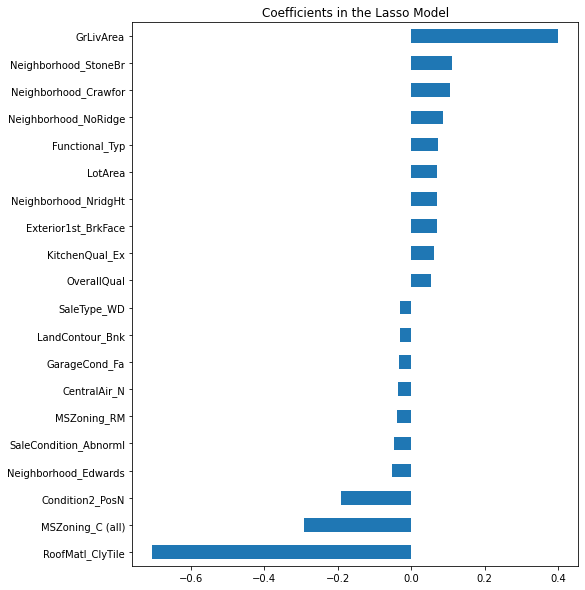

In [111]:
matplotlib.rcParams['figure.figsize']=(8.0, 10.0)
imp_coef.plot(kind='barh')
plt.title('Coefficients in the Lasso Model')

* GrLivArea가 가장 중요한 변수로 나옴. (=> the above ground area by area square feet. )
* 몇몇의 negative features들은 좀더 볼 가치가있어보인다. 
    * unbalanced categorical variables 에서 나온것으로 보임.
    
* 여기서 이슈는, 우리가 target변수 (SalePrice)와 수치형 변수 모두 로그변환을 해주어서 실제 단위를 해석하기어렵다.

**잔차 확인**

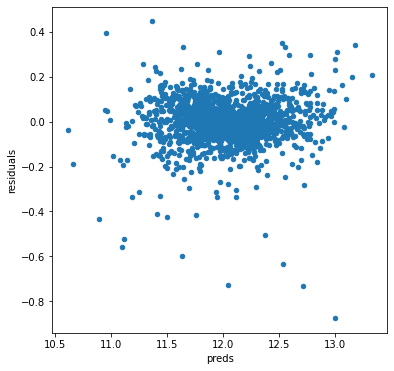

In [115]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

# 예측값과 실제y값
preds=pd.DataFrame({'preds':model_lasso.predict(X_train), 'true':y})
# 잔차 = 실제값 - 예측값
preds['residuals']=preds['true']-preds['preds']
preds.plot(x='preds', y='residuals',kind='scatter');

* 잔차가 패턴없이 잘 흩어져있는것으로 보임. good!
* 이제 test set으로 예측한 결과를 submit해서 리더보드에 올리기

### (3) Adding an xgboost model

In [1]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [5]:
conda list anaconda

# packages in environment at /Users/suhyun/anaconda3/envs/suhyun2:
#
# Name                    Version                   Build  Channel
_anaconda_depends         2019.03                  py36_0  
anaconda                  custom                   py36_1  
anaconda-client           1.7.2                    py36_0  
anaconda-navigator        1.9.7                    py36_0  
anaconda-project          0.8.2                    py36_0  

Note: you may need to restart the kernel to use updated packages.


In [3]:
from platform import python_version
print(python_version())

3.6.8


In [2]:
!pip install xgboost

  Using cached https://files.pythonhosted.org/packages/8e/cd/c1c48514cdd03d735d38d2de471474eb7adc53fc5278cb4a877a25a29976/xgboost-1.3.1.tar.gz
  Complete output from command /Users/suhyun/anaconda3/envs/suhyun2/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/gw/71qwknbd2kd5l033clsqykyw0000gn/T/pip-install-hzyp4vom/xgboost/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /private/var/folders/gw/71qwknbd2kd5l033clsqykyw0000gn/T/pip-wheel-gpd6pqrt --python-tag cp36:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.7-x86_64-3.6
  creating build/lib.macosx-10.7-x86_64-3.6/xgboost
  copying xgboost/rabit.py -> build/lib.macosx-10.7-x86_64-3.6/xgboost
  copying xgboost/callback.py -> build/lib.macosx-10.7-x86_64-3.6/xgboost
  copying xgboost/compat.py -> build/lib.macosx-10.7-x86_64-3.6/xgboost
  copying x

Failed to build xgboost
  Running setup.py install for xgboost ... error
    Complete output from command /Users/suhyun/anaconda3/envs/suhyun2/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/gw/71qwknbd2kd5l033clsqykyw0000gn/T/pip-install-hzyp4vom/xgboost/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /private/var/folders/gw/71qwknbd2kd5l033clsqykyw0000gn/T/pip-record-8zifa8d5/install-record.txt --single-version-externally-managed --compile:
    running install
    running build
    running build_py
    creating build
    creating build/lib.macosx-10.7-x86_64-3.6
    creating build/lib.macosx-10.7-x86_64-3.6/xgboost
    copying xgboost/rabit.py -> build/lib.macosx-10.7-x86_64-3.6/xgboost
    copying xgboost/callback.py -> build/lib.macosx-10.7-x86_64-3.6/xgboost
    copying xgboost/compat.py -> build/lib.macosx-10.7-x86_64-3.6/xgboost
    copying xgb

    copying xgboost/dmlc-core/src/io/hdfs_filesys.h -> build/lib.macosx-10.7-x86_64-3.6/xgboost/dmlc-core/src/io
    copying xgboost/dmlc-core/src/io/indexed_recordio_split.cc -> build/lib.macosx-10.7-x86_64-3.6/xgboost/dmlc-core/src/io
    copying xgboost/dmlc-core/src/io/indexed_recordio_split.h -> build/lib.macosx-10.7-x86_64-3.6/xgboost/dmlc-core/src/io
    copying xgboost/dmlc-core/src/io/input_split_base.cc -> build/lib.macosx-10.7-x86_64-3.6/xgboost/dmlc-core/src/io
    copying xgboost/dmlc-core/src/io/input_split_base.h -> build/lib.macosx-10.7-x86_64-3.6/xgboost/dmlc-core/src/io
    copying xgboost/dmlc-core/src/io/line_split.cc -> build/lib.macosx-10.7-x86_64-3.6/xgboost/dmlc-core/src/io
    copying xgboost/dmlc-core/src/io/line_split.h -> build/lib.macosx-10.7-x86_64-3.6/xgboost/dmlc-core/src/io
    copying xgboost/dmlc-core/src/io/local_filesys.cc -> build/lib.macosx-10.7-x86_64-3.6/xgboost/dmlc-core/src/io
    copying xgboost/dmlc-core/src/io/local_filesys.h -> build/lib.m

Command "/Users/suhyun/anaconda3/envs/suhyun2/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/gw/71qwknbd2kd5l033clsqykyw0000gn/T/pip-install-hzyp4vom/xgboost/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /private/var/folders/gw/71qwknbd2kd5l033clsqykyw0000gn/T/pip-record-8zifa8d5/install-record.txt --single-version-externally-managed --compile" failed with error code 1 in /private/var/folders/gw/71qwknbd2kd5l033clsqykyw0000gn/T/pip-install-hzyp4vom/xgboost/


In [3]:
!pip install cmake

    100% |████████████████████████████████| 42.8MB 412kB/s ta 0:00:011   50% |████████████████▎               | 21.8MB 2.0MB/s eta 0:00:11    67% |█████████████████████▌          | 28.7MB 1.2MB/s eta 0:00:13


In [7]:
conda remove xgboost

Solving environment: failed

PackagesNotFoundError: The following packages are missing from the target environment:
  - xgboost



Note: you may need to restart the kernel to use updated packages.


In [8]:
# 0.7 버전으로다시설치해보기
conda install -c aterrel xgboost=0.4.0

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                                         -failed

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - xgboost=0.4.0 -> python=2.7

Your python: defaults/osx-64::python==3.6.8=haf84260_0

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for the python version you are constrained to. Note that conda will not
change your python version to a different minor version unless you explicitly specify
that.




Note: you may need to restart the kernel to use updated packages.


In [14]:
conda install -c conda-forge xgboost

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::jupyter_console==6.0.0=py36_0
  - defaults/osx-64::jupyterlab_server==0.2.0=py36_0
  - defaults/osx-64::astropy==4.0=py36h1de35cc_0
  - defaults/osx-64::widgetsnbextension==3.4.2=py36_0
  - defaults/osx-64::imageio==2.6.1=py36_0
  - defaults/osx-64::datashape==0.5.4=py36_1
  - defaults/osx-64::scipy==1.4.1=py36h9fa6033_0
  - defaults/osx-64::pandas==1.0.0=py36h6c726b0_0
  - defaults/osx-64::_anaconda_depends==2019.03=py36_0
  - defaults/osx-64::blaze==0.11.3=py36_0
  - defaults/osx-64::patsy==0.5.1=py36_0
  - defaults/osx-64::numexpr==2.7.1=py36hce01a72_0
  - defaults/osx-64::_ipyw_jlab_nb_ext_conf==0.1.0=py36_0
  - defaults/osx-64::numpy-base==1.18.1=py36h6575580_1
  - defaults/osx-64::jupyterlab==0.35.4=py36hf63ae98_0
  - defaults/osx-64::pywavelets==1.1.1=py36h1de35cc_0
  - defaults/noarch::pytest-doctestplus==0.

Upload successful.

Note: you may need to restart the kernel to use updated packages.


In [12]:
import sys
print(sys.base_prefix)

/Users/suhyun/anaconda3/envs/suhyun2


In [13]:
import sys
!{sys.executable} -m pip install xgboost

  Using cached https://files.pythonhosted.org/packages/8e/cd/c1c48514cdd03d735d38d2de471474eb7adc53fc5278cb4a877a25a29976/xgboost-1.3.1.tar.gz
  Complete output from command /Users/suhyun/anaconda3/envs/suhyun2/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/gw/71qwknbd2kd5l033clsqykyw0000gn/T/pip-install-s2kj4ruz/xgboost/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /private/var/folders/gw/71qwknbd2kd5l033clsqykyw0000gn/T/pip-wheel-0pyabkar --python-tag cp36:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.7-x86_64-3.6
  creating build/lib.macosx-10.7-x86_64-3.6/xgboost
  copying xgboost/rabit.py -> build/lib.macosx-10.7-x86_64-3.6/xgboost
  copying xgboost/callback.py -> build/lib.macosx-10.7-x86_64-3.6/xgboost
  copying xgboost/compat.py -> build/lib.macosx-10.7-x86_64-3.6/xgboost
  copying x

Failed to build xgboost
  Running setup.py install for xgboost ... error
    Complete output from command /Users/suhyun/anaconda3/envs/suhyun2/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/gw/71qwknbd2kd5l033clsqykyw0000gn/T/pip-install-s2kj4ruz/xgboost/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /private/var/folders/gw/71qwknbd2kd5l033clsqykyw0000gn/T/pip-record-0tttry85/install-record.txt --single-version-externally-managed --compile:
    running install
    running build
    running build_py
    creating build
    creating build/lib.macosx-10.7-x86_64-3.6
    creating build/lib.macosx-10.7-x86_64-3.6/xgboost
    copying xgboost/rabit.py -> build/lib.macosx-10.7-x86_64-3.6/xgboost
    copying xgboost/callback.py -> build/lib.macosx-10.7-x86_64-3.6/xgboost
    copying xgboost/compat.py -> build/lib.macosx-10.7-x86_64-3.6/xgboost
    copying xgb

Command "/Users/suhyun/anaconda3/envs/suhyun2/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/gw/71qwknbd2kd5l033clsqykyw0000gn/T/pip-install-s2kj4ruz/xgboost/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /private/var/folders/gw/71qwknbd2kd5l033clsqykyw0000gn/T/pip-record-0tttry85/install-record.txt --single-version-externally-managed --compile" failed with error code 1 in /private/var/folders/gw/71qwknbd2kd5l033clsqykyw0000gn/T/pip-install-s2kj4ruz/xgboost/
